<a href="https://colab.research.google.com/github/SakanaAI/asal/blob/main/asal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automating the Search for Artificial Life with Foundation Models

Automated Search for Artificial Life (ASAL) is an algorithm to automatically discover interesting ALife simulations!

Rather than hand designing a particular simulation, just parameterize a big set of simulations (e.g. all Lenia simulations) and automatically search over them.

This notebook will show you how to 
- Run ASAL
    - Search for supervised target simulations specified by a single prompt
    - Search for supervised target simulations specified by multiple temporal prompts
    - Search for open-ended simulations
    - Search for supervised target + open-ended simulations
    - Illuminate the entire substrate by finding a diverse set of simulations
- Give some tips on how to get the search to work for whatever you want to discover.
- Show you how to play around with other substrates we implemented.
- Load in previously discovered lifeforms from our large scale searches

NOTE: If you are in Google Colab, make sure to change the runtime to have a GPU!

This notebook was run on Sakana AI's cluster.
Because of the nondeterminism of the jax compilation on different hardware and the chaotic nature of the simulations, your result will probably be different than these exact pictures.

In [ ]:
%load_ext autoreload
%autoreload 2
import os, sys
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import os, sys, glob, pickle
from functools import partial

import jax
import jax.numpy as jnp
from jax.random import split
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

import substrates
import foundation_models
from rollout import rollout_simulation
import asal_metrics
import util


## Supervised Target (Single Target)

To begin, let's search for a Lenia simulation which produces a final state matching a single prompt `"a caterpillar"`.

Run this command:

In [ ]:
! python main_opt.py --seed=0 --save_dir="./data/supervised_1" --substrate='plenia' --time_sampling=1 --prompts="a caterpillar" --coef_prompt=1. --coef_softmax=0. --coef_oe=0. --bs=1 --pop_size=16 --n_iters=1000 --sigma=0.1

Namespace(seed=0, save_dir='./data/supervised_1', substrate='plenia', rollout_steps=None, foundation_model='clip', time_sampling=1, prompts='a caterpillar', coef_prompt=1.0, coef_softmax=0.0, coef_oe=0.0, bs=1, pop_size=16, n_iters=1000, sigma=0.1)
ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 6 parameters detected for optimization.
 20%|████▍                 | 200/1000 [00:25<00:41, 19.17it/s, best_loss=-0.262]

In [ ]:
save_dir = "./data/supervised_1"
data = util.load_pkl(save_dir, "data") # load optimization data
params, best_loss = util.load_pkl(save_dir, "best") # load the best parameters found

# fm = foundation_models.create_foundation_model('clip') # we don't need the foundation model for just the rollout currently
substrate = substrates.create_substrate('plenia') # create the substrate
substrate = substrates.FlattenSubstrateParameters(substrate) # useful wrapper to flatten the substrate parameters

rollout_fn = partial(rollout_simulation, s0=None, substrate=substrate, fm=None, rollout_steps=substrate.rollout_steps, time_sampling=8, img_size=224, return_state=False)
rollout_fn = jax.jit(rollout_fn)

rng = jax.random.PRNGKey(0)
rollout_data = rollout_fn(rng, params) # rollout the simulation using this rng seed and simulation parameters

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 6 parameters detected for optimization.


: 

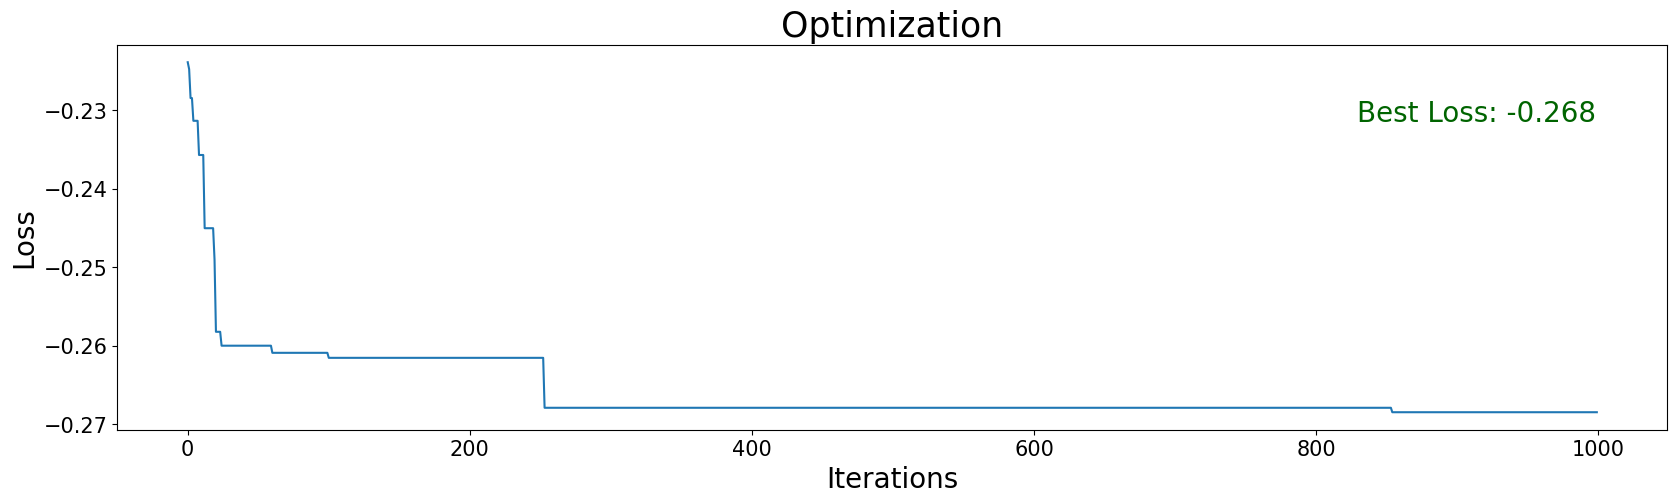

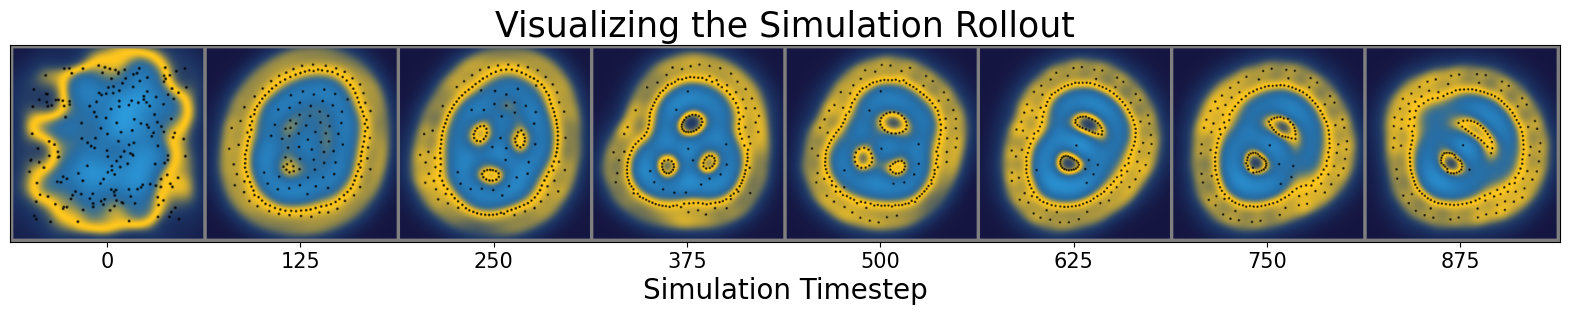

: 

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(data['best_loss'])
plt.xlabel("Iterations", fontsize=20); plt.ylabel("Loss", fontsize=20); plt.title("Optimization", fontsize=25)
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.text(0.8, 0.8, f"Best Loss: {best_loss:.3f}", color='darkgreen', fontsize=20, transform=plt.gca().transAxes)
plt.show()

plt.figure(figsize=(20, 6))
img = np.array(rollout_data['rgb'])
img = np.pad(img, ((0, 0), (2, 2), (2, 2), (0, 0)), constant_values=0.5)
img = rearrange(img, "T H W D -> H (T W) D")
img = np.pad(img, ((2, 2), (2, 2), (0, 0)), constant_values=0.5)
plt.imshow(img)
plt.xticks(np.arange(0, 8)*228+228//2, np.arange(0, 8)*substrate.rollout_steps//8, fontsize=15); plt.yticks([], fontsize=15)
plt.title("Visualizing the Simulation Rollout", fontsize=25)
plt.xlabel("Simulation Timestep", fontsize=20)
plt.show()

: 

## Supervised Target (Temporal Targets)

Now, let's search for a Lenia simulation which produces a trajectory going from `"a small biological cell"` to `"a large biological cell"`.

Although not required (and not originally part of ASAL), it sometimes helps to include and tune the coef_softmax parameter below to incentivize the simulation to find unique images for each prompt rather than one static image satisfying both prompts.

Run this command:

In [ ]:
! python main_opt.py --seed=4 --save_dir="./data/supervised_temporal_1" --substrate='plenia' --time_sampling=2 --prompts="a small biological cell;a large biological cell" --coef_prompt=1. --coef_softmax=0.1 --coef_oe=0. --bs=1 --pop_size=16 --n_iters=1000 --sigma=0.1

/home/kazuyahoribe/.pyenv/versions/miniconda3-4.7.12/envs/asal/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Namespace(seed=4, save_dir='./data/supervised_temporal_1', substrate='plenia', rollout_steps=None, foundation_model='clip', time_sampling=2, prompts='a small biological cell;a large biological cell', coef_prompt=1.0, coef_softmax=0.1, coef_oe=0.0, bs=1, pop_size=16, n_iters=1000, sigma=0.1)
ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 6 parameters detected for optimization.
100%|██████████████████████| 1000/1000 [01:34<00:00, 10.56it/s, best_loss=-0.27]


: 

In [ ]:
save_dir = "./data/supervised_temporal_1/"
data = util.load_pkl(save_dir, "data") # load optimization data
params, best_loss = util.load_pkl(save_dir, "best") # load the best parameters found

# fm = foundation_models.create_foundation_model('clip') # we don't need the foundation model for just the rollout currently
substrate = substrates.create_substrate('plenia') # create the substrate
substrate = substrates.FlattenSubstrateParameters(substrate) # useful wrapper to flatten the substrate parameters

rollout_fn = partial(rollout_simulation, s0=None, substrate=substrate, fm=None, rollout_steps=substrate.rollout_steps, time_sampling=8, img_size=224, return_state=False)
rollout_fn = jax.jit(rollout_fn)

rng = jax.random.PRNGKey(0)
rollout_data = rollout_fn(rng, params) # rollout the simulation using this rng seed and simulation parameters

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 6 parameters detected for optimization.


: 

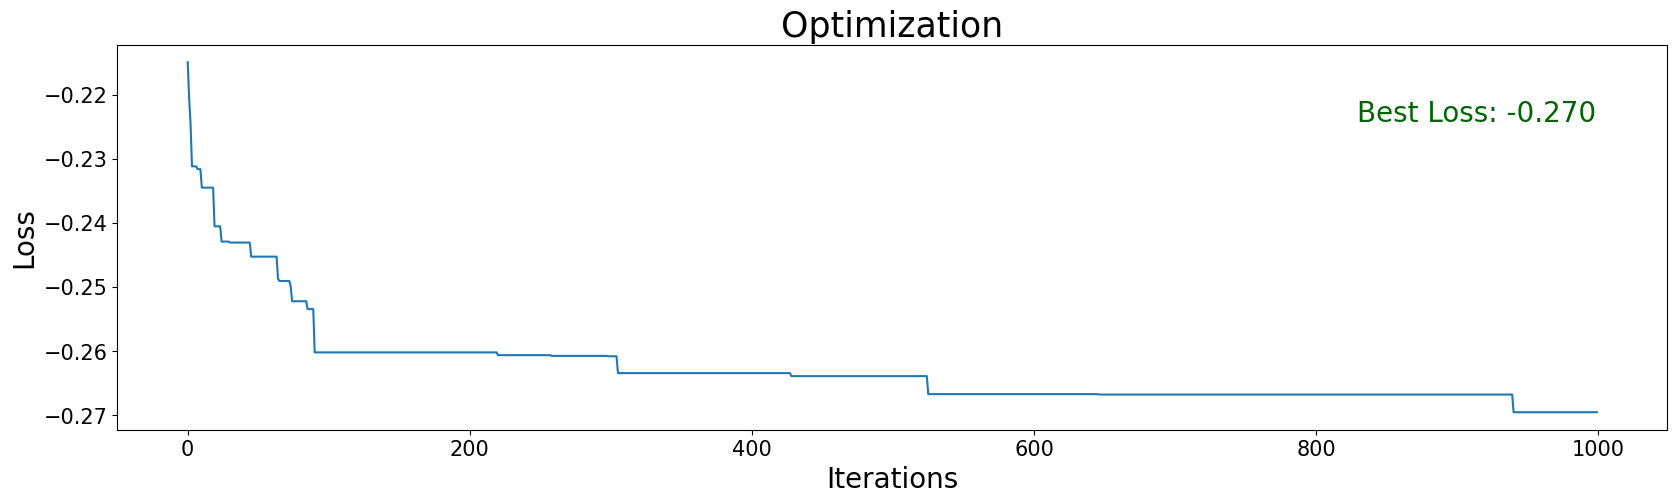

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


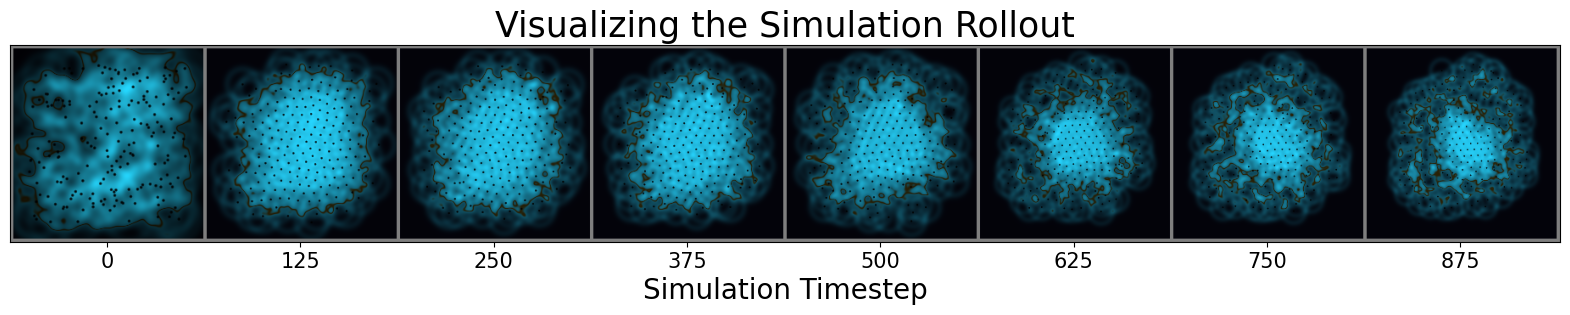

: 

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(data['best_loss'])
plt.xlabel("Iterations", fontsize=20); plt.ylabel("Loss", fontsize=20); plt.title("Optimization", fontsize=25)
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.text(0.8, 0.8, f"Best Loss: {best_loss:.3f}", color='darkgreen', fontsize=20, transform=plt.gca().transAxes)
plt.show()

plt.figure(figsize=(20, 6))
img = np.array(rollout_data['rgb'])
img = np.pad(img, ((0, 0), (2, 2), (2, 2), (0, 0)), constant_values=0.5)
img = rearrange(img, "T H W D -> H (T W) D")
img = np.pad(img, ((2, 2), (2, 2), (0, 0)), constant_values=0.5)
plt.imshow(img)
plt.xticks(np.arange(0, 8)*228+228//2, np.arange(0, 8)*substrate.rollout_steps//8, fontsize=15); plt.yticks([], fontsize=15)
plt.title("Visualizing the Simulation Rollout", fontsize=25)
plt.xlabel("Simulation Timestep", fontsize=20)
plt.show()

: 

## Open-Endedness

Great! Now let's discover a Lenia simulation which is open-ended, meaning it generates novelty in time.

Run this command:

In [ ]:
! python main_opt.py --seed=3 --save_dir="./data/open_endedness_1" --substrate='plenia' --time_sampling=32 --prompts="" --coef_prompt=0. --coef_softmax=0. --coef_oe=1. --bs=1 --pop_size=16 --n_iters=1000 --sigma=0.1

/home/kazuyahoribe/.pyenv/versions/miniconda3-4.7.12/envs/asal/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Namespace(seed=3, save_dir='./data/open_endedness_1', substrate='plenia', rollout_steps=None, foundation_model='clip', time_sampling=32, prompts='', coef_prompt=0.0, coef_softmax=0.0, coef_oe=1.0, bs=1, pop_size=16, n_iters=1000, sigma=0.1)
ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 6 parameters detected for optimization.
100%|██████████████████████| 1000/1000 [13:06<00:00,  1.27it/s, best_loss=0.912]


: 

In [ ]:
save_dir = "./data/open_endedness_1"
data = util.load_pkl(save_dir, "data") # load optimization data
params, best_loss = util.load_pkl(save_dir, "best") # load the best parameters found

# fm = foundation_models.create_foundation_model('clip') # we don't need the foundation model for just the rollout currently
substrate = substrates.create_substrate('plenia') # create the substrate
substrate = substrates.FlattenSubstrateParameters(substrate) # useful wrapper to flatten the substrate parameters

rollout_fn = partial(rollout_simulation, s0=None, substrate=substrate, fm=None, rollout_steps=substrate.rollout_steps, time_sampling=8, img_size=224, return_state=False)
rollout_fn = jax.jit(rollout_fn)

rng = jax.random.PRNGKey(0)
rollout_data = rollout_fn(rng, params) # rollout the simulation using this rng seed and simulation parameters

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 6 parameters detected for optimization.


: 

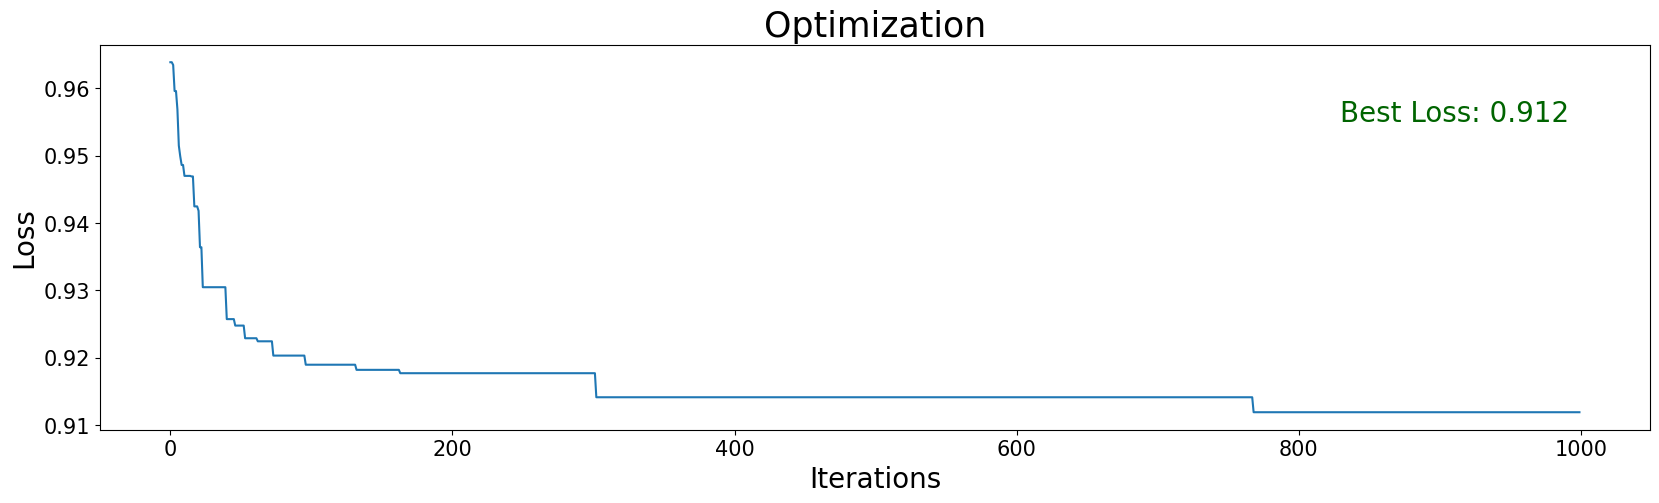

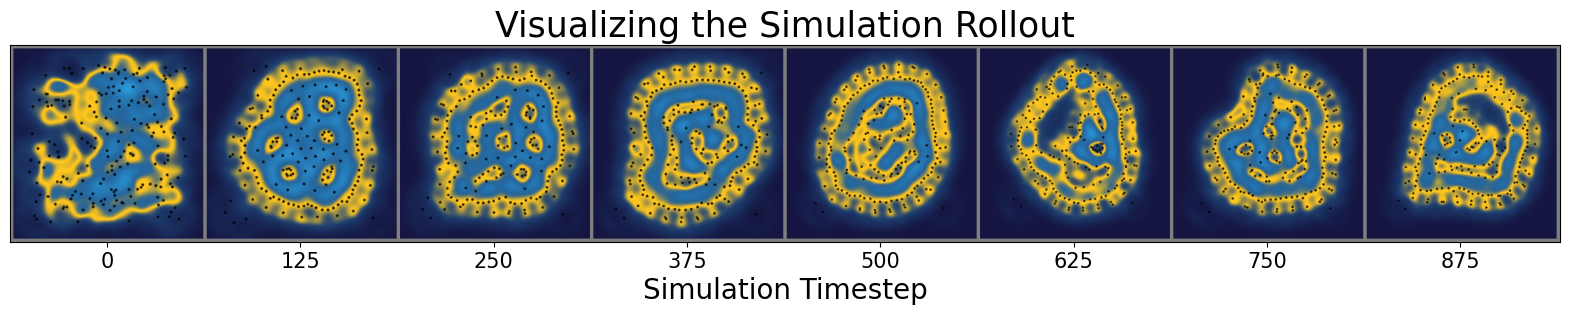

: 

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(data['best_loss'])
plt.xlabel("Iterations", fontsize=20); plt.ylabel("Loss", fontsize=20); plt.title("Optimization", fontsize=25)
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.text(0.8, 0.8, f"Best Loss: {best_loss:.3f}", color='darkgreen', fontsize=20, transform=plt.gca().transAxes)
plt.show()

plt.figure(figsize=(20, 6))
img = np.array(rollout_data['rgb'])
img = np.pad(img, ((0, 0), (2, 2), (2, 2), (0, 0)), constant_values=0.5)
img = rearrange(img, "T H W D -> H (T W) D")
img = np.pad(img, ((2, 2), (2, 2), (0, 0)), constant_values=0.5)
plt.imshow(img)
plt.xticks(np.arange(0, 8)*228+228//2, np.arange(0, 8)*substrate.rollout_steps//8, fontsize=15); plt.yticks([], fontsize=15)
plt.title("Visualizing the Simulation Rollout", fontsize=25)
plt.xlabel("Simulation Timestep", fontsize=20)
plt.show()

: 

## Supervised Target + Open-Endedness

What if we combine the supervised target and open-endedness scores to optimize for?
Can we find an open-ended `"diverse ecosystem of cells"`?

Let's try it!

In [ ]:
! python main_opt.py --seed=0 --save_dir="./data/st_oe_1" --substrate='plenia' --time_sampling=32 --prompts="a diverse ecosystem of cells" --coef_prompt=1. --coef_softmax=0. --coef_oe=1. --bs=1 --pop_size=16 --n_iters=1000 --sigma=0.1

/home/kazuyahoribe/.pyenv/versions/miniconda3-4.7.12/envs/asal/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Namespace(seed=0, save_dir='./data/st_oe_1', substrate='plenia', rollout_steps=None, foundation_model='clip', time_sampling=32, prompts='a diverse ecosystem of cells', coef_prompt=1.0, coef_softmax=0.0, coef_oe=1.0, bs=1, pop_size=16, n_iters=1000, sigma=0.1)
ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 6 parameters detected for optimization.
100%|██████████████████████| 1000/1000 [11:48<00:00,  1.41it/s, best_loss=0.658]


: 

In [ ]:
save_dir = "./data/st_oe_1"
data = util.load_pkl(save_dir, "data") # load optimization data
params, best_loss = util.load_pkl(save_dir, "best") # load the best parameters found

# fm = foundation_models.create_foundation_model('clip') # we don't need the foundation model for just the rollout currently
substrate = substrates.create_substrate('plenia') # create the substrate
substrate = substrates.FlattenSubstrateParameters(substrate) # useful wrapper to flatten the substrate parameters

rollout_fn = partial(rollout_simulation, s0=None, substrate=substrate, fm=None, rollout_steps=substrate.rollout_steps, time_sampling=8, img_size=224, return_state=False)
rollout_fn = jax.jit(rollout_fn)

rng = jax.random.PRNGKey(0)
rollout_data = rollout_fn(rng, params) # rollout the simulation using this rng seed and simulation parameters

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 6 parameters detected for optimization.


: 

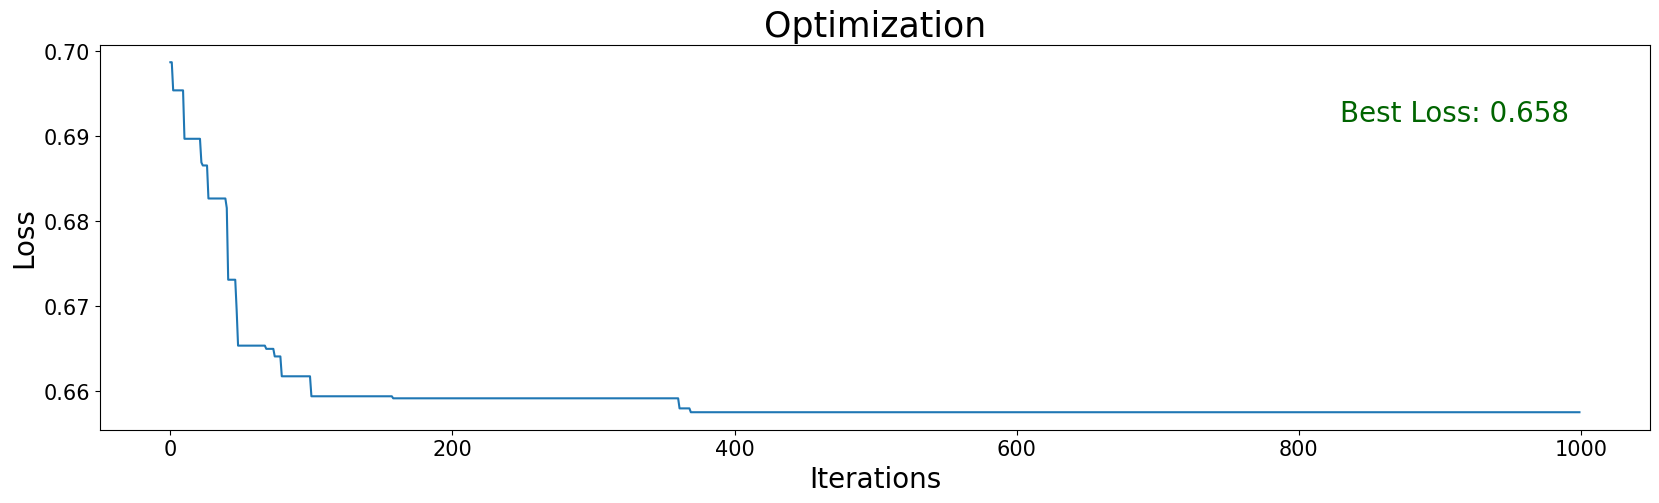

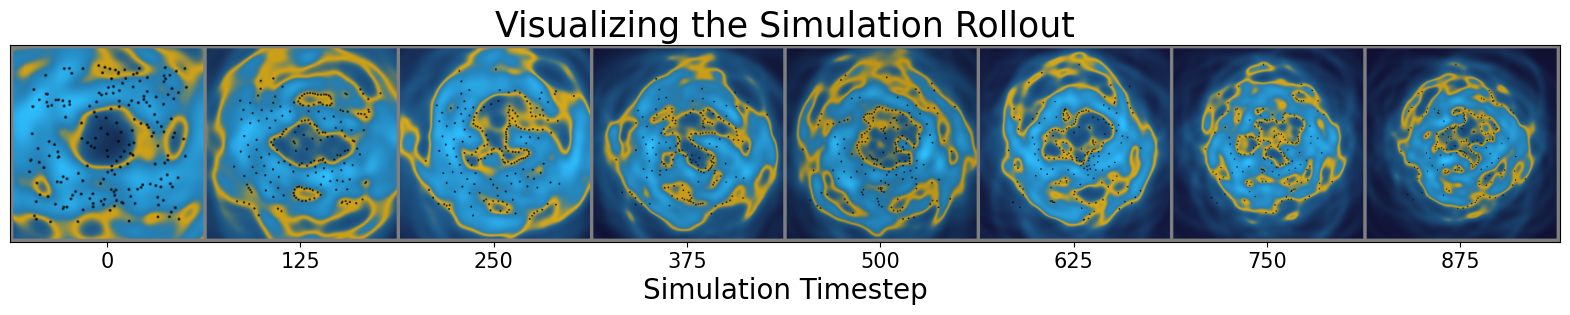

: 

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(data['best_loss'])
plt.xlabel("Iterations", fontsize=20); plt.ylabel("Loss", fontsize=20); plt.title("Optimization", fontsize=25)
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.text(0.8, 0.8, f"Best Loss: {best_loss:.3f}", color='darkgreen', fontsize=20, transform=plt.gca().transAxes)
plt.show()

plt.figure(figsize=(20, 6))
img = np.array(rollout_data['rgb'])
img = np.pad(img, ((0, 0), (2, 2), (2, 2), (0, 0)), constant_values=0.5)
img = rearrange(img, "T H W D -> H (T W) D")
img = np.pad(img, ((2, 2), (2, 2), (0, 0)), constant_values=0.5)
plt.imshow(img)
plt.xticks(np.arange(0, 8)*228+228//2, np.arange(0, 8)*substrate.rollout_steps//8, fontsize=15); plt.yticks([], fontsize=15)
plt.title("Visualizing the Simulation Rollout", fontsize=25)
plt.xlabel("Simulation Timestep", fontsize=20)
plt.show()

: 

## Illumination

Great! Now let's try illuminating the entire Lenia substrate and find a diverse set of Lenia creatures!

Run this command in the terminal:

In [ ]:
! python main_illuminate.py --seed=0 --save_dir="./data/illuminate_1" --substrate='plenia' --n_child=32 --pop_size=256 --n_iters=1000 --sigma=0.1

/home/kazuyahoribe/.pyenv/versions/miniconda3-4.7.12/envs/asal/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Namespace(seed=0, save_dir='./data/illuminate_1', substrate='plenia', rollout_steps=None, foundation_model='clip', k_nbrs=2, n_child=32, pop_size=256, n_iters=1000, sigma=0.1)
ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 6 parameters detected for optimization.
100%|███████████████████████████| 1000/1000 [02:17<00:00,  7.28it/s, loss=0.884]


: 

In [ ]:
save_dir = "./data/illuminate_1"
data = util.load_pkl(save_dir, "data") # load optimization data
pop = util.load_pkl(save_dir, "pop") # load the best parameters found
params = pop['params']

# fm = foundation_models.create_foundation_model('clip')
substrate = substrates.create_substrate('plenia')
substrate = substrates.FlattenSubstrateParameters(substrate)

rollout_fn = partial(rollout_simulation, s0=None, substrate=substrate, fm=None, rollout_steps=substrate.rollout_steps, time_sampling='final', img_size=224, return_state=False)
rollout_fn = jax.jit(rollout_fn)

rng = jax.random.PRNGKey(0)

rollout_data = [rollout_fn(rng, p) for p in params] # rollout the simulation using this rng seed and simulation parameters
rollout_data = jax.tree.map(lambda *x: jnp.stack(x, axis=0), *rollout_data) # stack the list of rollout data into a single tree
# note if you have enough GPU memory, you can just do vmap on rollout_fn!

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 6 parameters detected for optimization.


: 

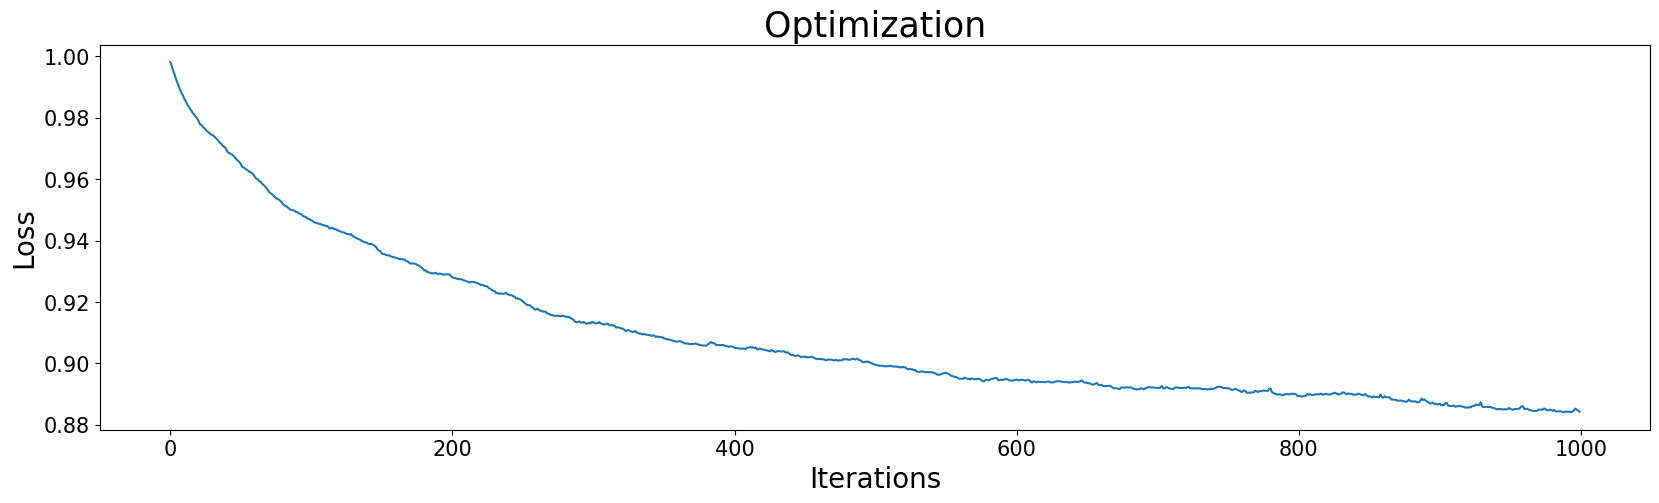

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


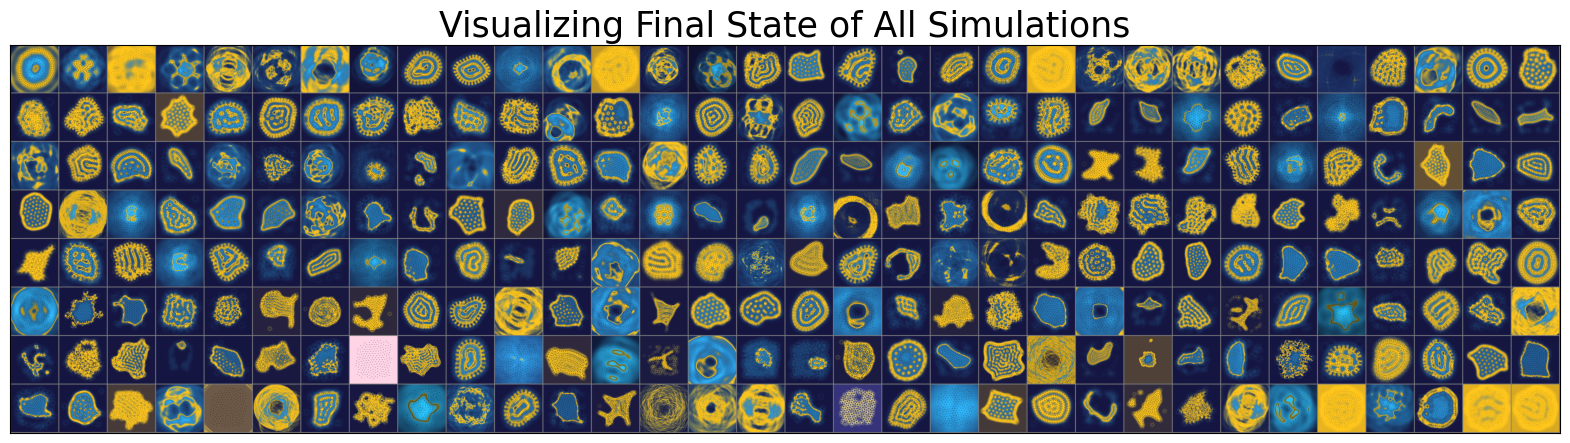

: 

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(data['loss'])
plt.xlabel("Iterations", fontsize=20); plt.ylabel("Loss", fontsize=20); plt.title("Optimization", fontsize=25)
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.show()

plt.figure(figsize=(20, 6))
img = np.array(rollout_data['rgb'])
img = np.pad(img, ((0, 0), (2, 2), (2, 2), (0, 0)), constant_values=0.5)
img = rearrange(img, "(R C) H W D -> (R H) (C W) D", R=8)
img = np.pad(img, ((2, 2), (2, 2), (0, 0)), constant_values=0.5)
plt.imshow(img)
plt.xticks([], fontsize=15); plt.yticks([], fontsize=15)
plt.title("Visualizing Final State of All Simulations", fontsize=25)
plt.show()

: 